<a href="https://colab.research.google.com/github/SudeepSarkar/Undergraduate-Computer-Vision/blob/main/CAP_4400_Lecture_12_2D_Nonlinear_Estimation_and_RANSAC.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Copyright (c) 2021, Sudeep Sarkar, University of South Florida, Tampa

# Topics Covered

* RANSAC: Random Sample Consensus strategy for fitting in the presence of outliers

* Estimation of parameters of non-linear transformations using gradient descent and Newton's method.

* Using PyTorch's autograd to perform the estimation



# Initialize notebook

In [1]:
from google.colab import drive
drive.mount('/content/drive')
!ls '/content/drive/MyDrive/Colab Notebooks/CAP 4410 - UG Computer Vision/data'

Mounted at /content/drive
 apple.jpg				     mountain_peak_1.png
'Armes 1.png'				     mountain_peak_2.png
'Armes 2.png'				     parking_lot_meva_1.png
 declaration_of_independence_stone_630.jpg   parking_lot_meva_2.png
 Fig3_3a.jpg				     parking_lot_meva_3.png
 Fig3_4a.jpg				    'Road Signs Kaggle'
 Fig3_4c.jpg				    'Superbowl 2021_1.png'
 house_1.png				    'Superbowl 2021_2.png'
 house_2.png				    'Superbowl 2021_3.png'
 lizard.jpg				     Total-Text-Dataset


In [2]:
import numpy as np
import torch

import matplotlib.pyplot as plt
import scipy.ndimage as scimage
from skimage.transform import warp
import torch.nn as nn
from skimage import io

!pip install opencv-contrib-python==4.4.0.44
import cv2
print (cv2 .__version__)

np.set_printoptions(precision=2, suppress=True)
torch.set_printoptions(precision=2, sci_mode=False)

     |████████████████████████████████| 55.7 MB 51 kB/s 
  Attempting uninstall: opencv-contrib-python
    Found existing installation: opencv-contrib-python 4.1.2.30
    Uninstalling opencv-contrib-python-4.1.2.30:
      Successfully uninstalled opencv-contrib-python-4.1.2.30
4.4.0


## Code: Detect and match SIFT keypoints between two images

In [3]:
def detect_and_match_keypoints (image_1, image_2) :
    # input are just two images
    # returns SIFT key points and descriptors for each image along with sorted match list (plus pairs of point matching coordinates) 
    # SIFT with default parameters
    sift = cv2.SIFT_create(nOctaveLayers = 3, contrastThreshold = 0.04, edgeThreshold = 10, sigma = 1.6)

    keypoints_1, descriptors_1 = sift.detectAndCompute(image_1, None)
    keypoints_2, descriptors_2 = sift.detectAndCompute(image_2, None)

    # FEATURE MATCHING
    bf = cv2.BFMatcher(cv2.NORM_L1, crossCheck=True)

    matches = bf.match(descriptors_1, descriptors_2)
    matches = sorted(matches, key = lambda x:x.distance)
    X_1 = []
    X_2 = []
    for i in range(len(matches)) :
        X_1.append([keypoints_1[matches[i].queryIdx].pt[0], keypoints_1[matches[i].queryIdx].pt[1]])
        X_2.append([keypoints_2[matches[i].trainIdx].pt[0], keypoints_2[matches[i].trainIdx].pt[1]])
    X_1 = np.array(X_1)
    X_2 = np.array(X_2)

    return(X_1, X_2, keypoints_1, keypoints_2, matches)

## Code: SIFT keypoint detection and matching

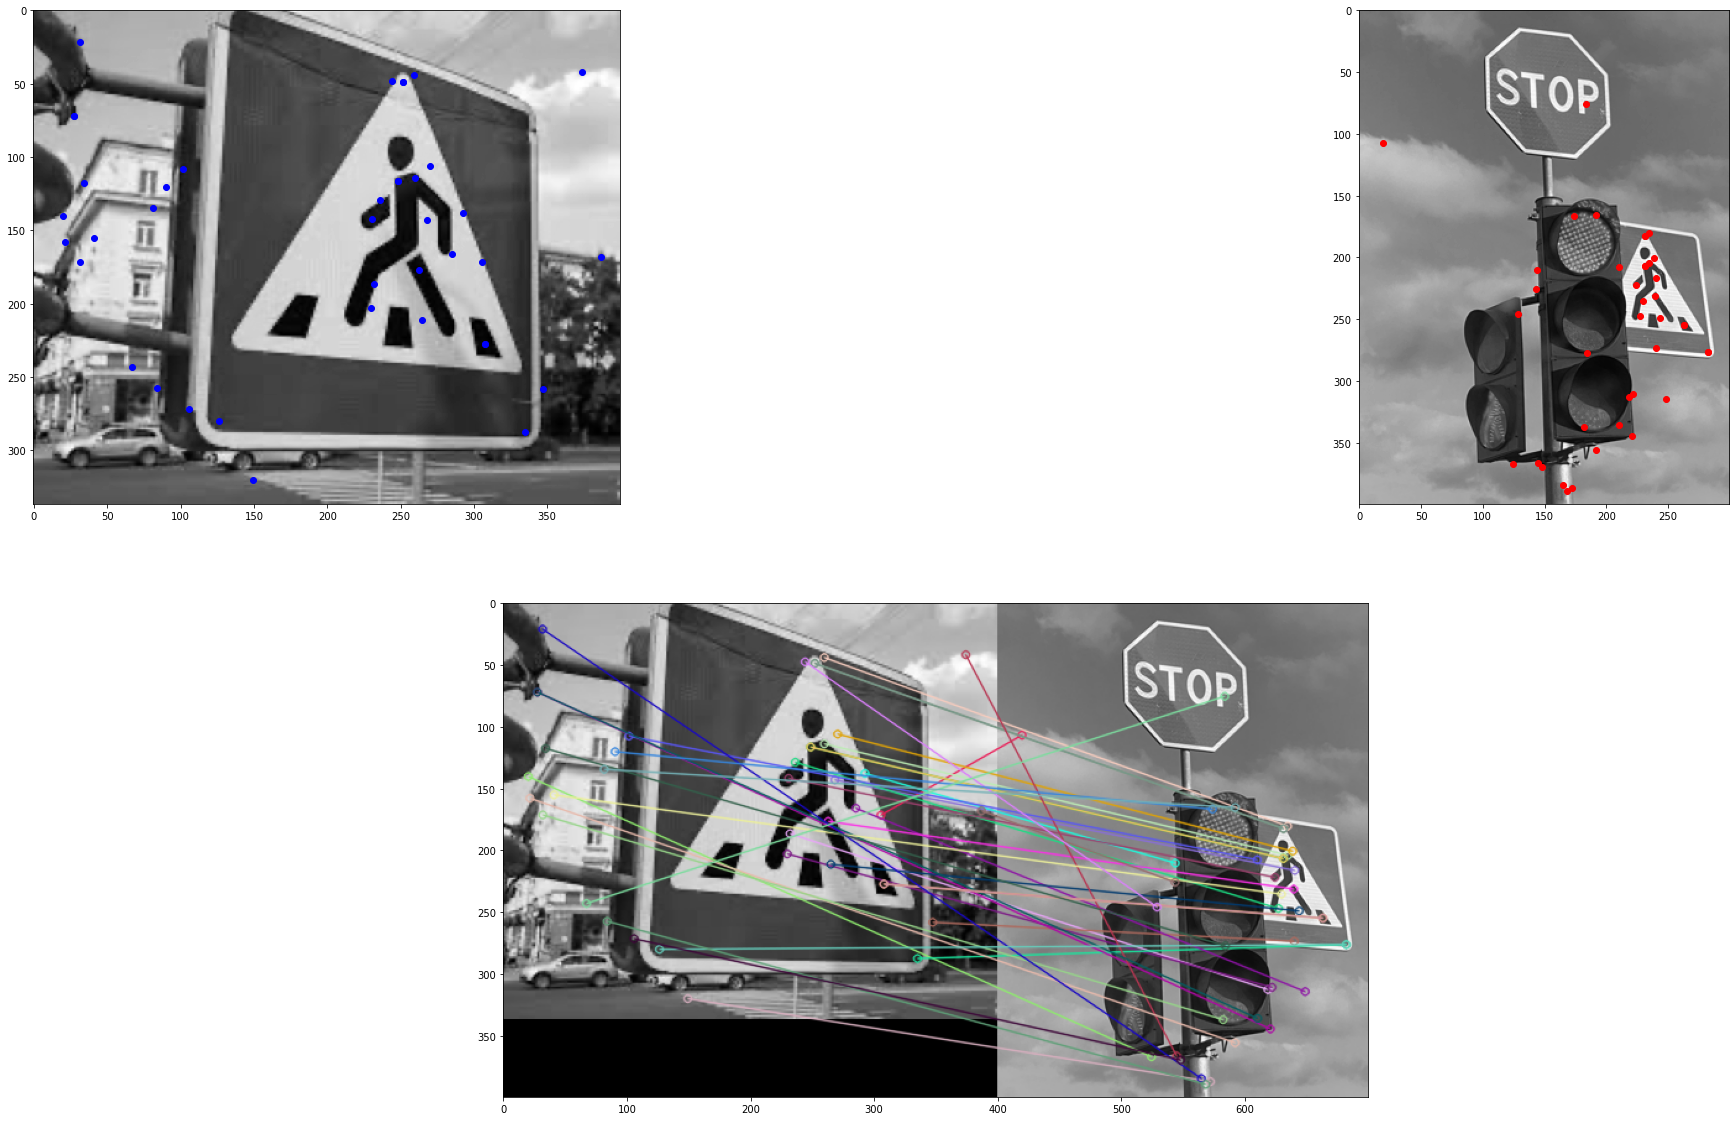

In [4]:
#image_1 = io.imread('https://i.stack.imgur.com/Er7vx.png')
#image_2 = io.imread('https://i.stack.imgur.com/gAz96.png')

image_1 = io.imread('/content/drive/MyDrive/Colab Notebooks/CAP 4410 - UG Computer Vision/data/Road Signs Kaggle/images/road153.png')
image_2 = io.imread('/content/drive/MyDrive/Colab Notebooks/CAP 4410 - UG Computer Vision/data/Road Signs Kaggle/images/road824.png')

image_1 = cv2.cvtColor(image_1, cv2.COLOR_RGB2BGR) # change from scikit RGB to cv2 BGR format for color images 
image_2 = cv2.cvtColor(image_2, cv2.COLOR_RGB2BGR)
image_1 = cv2.cvtColor(image_1, cv2.COLOR_BGR2GRAY) # change from color to gray
image_2 = cv2.cvtColor(image_2, cv2.COLOR_BGR2GRAY)

X_1, X_2, keypoints_1, keypoints_2, matches = detect_and_match_keypoints (image_1, image_2)
num_matches = 40 # select only the best num_matches matches
X_1 = X_1[:num_matches,:]
X_2 = X_2[:num_matches,:]

#----------------------------------Display-------------------------------------------------------
# draw matches
match_image = cv2.drawMatches(image_1, keypoints_1, image_2, keypoints_2, matches[:num_matches], image_2, flags=2)

plt.figure(figsize=(40,20))
plt.subplot(221)
plt.imshow(image_1, 'gray')
plt.plot(X_1[:,0], X_1[:,1], 'bo')
plt.subplot(222)
plt.imshow(image_2, 'gray')
plt.plot(X_2[:,0], X_2[:,1], 'ro')
plt.subplot(212)
plt.imshow(match_image);

## Code: QR based inverse computation used in affine

In [5]:
def qr_solve (H, b) :
    # H is n by n matrix, b is a n by 1 vector
    # returns a n by 1 vector as a solution
    
    Q, R = np.linalg.qr(H, 'reduced')
    b_dash = Q.transpose(1,0) @ b
    Np = b_dash.shape[0]
    del_p = np.zeros((Np, 1))
    for i in range(Np-1, -1, -1): # work from the last row of R
        sum_r_p = [0]
        for j in range(i+1, Np, 1) :
            sum_r_p += R[i, j]*del_p[j]
        del_p[i] = (b_dash[i]- sum_r_p)/R[i,i]

    return(del_p)

## Code: Affine fitting to point sets

In [7]:
def fit_affine (X, X_dash, select_flag) :
    # input: two 2D points sets, 3 by N arrays of homogeneous representation of the points
    # select_flag: 1D array of 0 an 1 indicating which points to use in the estimation.
    # output: residual of fit and the best fitting affine transformation

    # Compute the matrix H from the point coordinate moments
    M = X @ np.diag(select_flag) @ X.transpose(1,0)
    H1 = np.column_stack((M, np.zeros((3,3))))
    H2 = np.column_stack((np.zeros((3,3)), M))
    H = np.row_stack((H1, H2))

    # vector b
    b_dash = X @ np.diag(select_flag) @(X_dash - X).transpose(1,0)
    b = np.row_stack((b_dash[:,0][:,None], b_dash[:,1][:,None]))

    p = qr_solve (H, b) 

    p = p.squeeze()
    # the parameter vector is [a_00, a_01, t_x, a_10, a_11, t_y]
    # rearrange it back into homogeneous matrix representation
    T_affine = np.row_stack((p.reshape(2, 3), [0, 0, 0])) + np.eye(3)

    X_t = T_affine @ X
    residual_error = np.sum(np.power((X_dash - X_t), 2))
    return(residual_error, T_affine)


## Code: Detect inliers

In [9]:
def detect_intliers (X, X_dash, Transform, acceptable_error = 2) :
    # input: two 2D points sets, 3 by N arrays of homogeneous representation of the points
    # Transform: estimated transform to use to detect inliers.
    # acceptable_error - amount of average pixel error that is acceptable for inliers
    # output is an 1D array of size equal to the number of points with 0 or 1, 
    #        with 1 indicating the corresponding point is an inlier

    X_t = Transform @ X
    X_t = np.divide(X_t, X_t [2,:]) # normalized homogenous coordinates
    X_dash = np.divide(X_dash, X_dash [2,:]) # normalized homogenous coordinates
       
    error =  (X_dash - X_t)
    residual_error = np.sum(np.power(error, 2), axis=0)
    inliers  = np.where(residual_error < (acceptable_error*acceptable_error), 1, 0)
    
    return(inliers)


## Code: RANSAC

In [11]:
def ransac_fit (Points_1, Points_2, fit_function, acceptable_error = 2) :
    # input: two 2D points sets, each of size N by 2
    # fit_function: a function that computes the best fit, e.g. affine_fit
    # acceptable_error - amount of average pixel error that is acceptable
    # output: the best inlier flags and the best fitting transformation returned by fit_function

    # Rearrange the points in 3 by N arrays of homogeneous representation of the points
    X = np.row_stack((Points_1.transpose(1,0), np.ones((1, Points_1.shape[0]))))
    X_dash = np.row_stack((Points_2.transpose(1,0), np.ones((1, Points_2.shape[0]))))
    
    N = X.shape[1]
    best_inliers = np.zeros((N,))
    for i in range(10000) :
        indices = np.random.choice(range(N), 3, replace=False)
        selected_pts = np.zeros((N,))
        selected_pts[indices] = 1
        residual_error, transform = fit_function (X, X_dash, selected_pts)
        inliers = detect_intliers (X, X_dash, transform, acceptable_error)
        if (np.sum(inliers) > np.sum(best_inliers)) :
            best_inliers = inliers
            transform_best = transform
            print('inlier:', np.sum(best_inliers), 'of ', N)

    return(best_inliers, transform_best)

##Code: RANSAC used to reject outliers in correspondences

inlier: 4 of  40
inlier: 13 of  40
inlier: 14 of  40
Matches=[0 0 0 0 0 1 0 1 1 0 1 1 1 0 0 1 1 1 0 1 1 0 1 0 0 0 0 0 1 1 0 0 0 0 0 0 0
 0 0 0]
 T =
[[  0.43   0.04 120.61]
 [ -0.02   0.41 166.69]
 [  0.     0.     1.  ]]
 T_inv =
[[   2.32   -0.25 -237.69]
 [   0.09    2.42 -415.61]
 [   0.      0.      1.  ]]


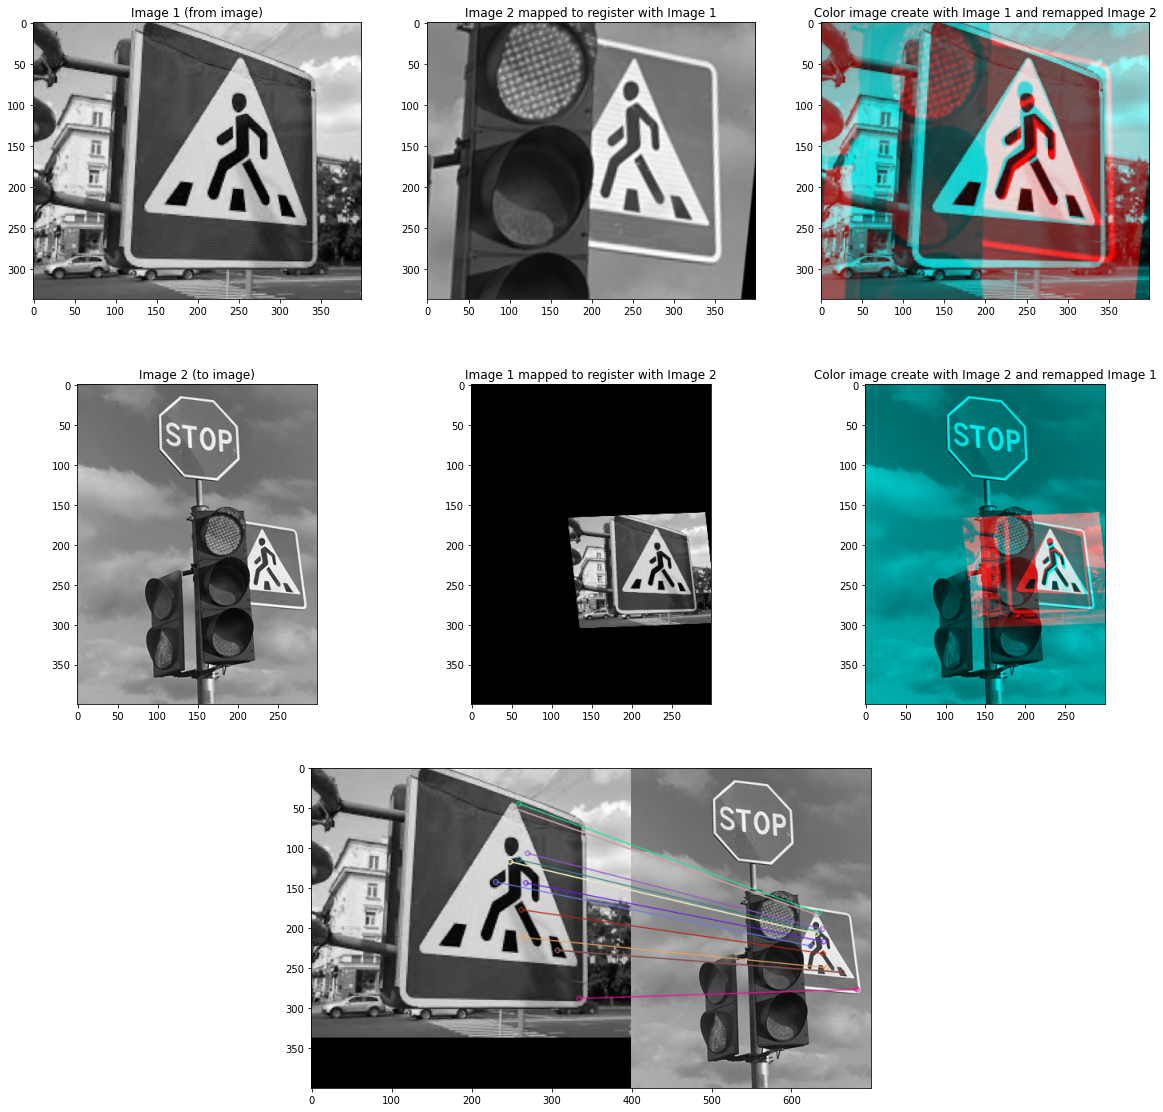

In [13]:
from skimage.transform import warp

#------------------------------------------------------------------------------
selected_matches, T_affine = ransac_fit(X_1, X_2, fit_affine, acceptable_error=6)
#------------------------------------------------------------------------------

T_affine_inv = np.linalg.inv(T_affine)
print('Matches={}\n T =\n{}\n T_inv =\n{}'.format(selected_matches, T_affine, T_affine_inv))

warped_1_into_2 = warp(image_1, inverse_map=T_affine_inv, output_shape=image_2.shape)

warped_2_into_1 = warp(image_2, inverse_map=T_affine, output_shape=image_1.shape)

# build an RGB image with the registered images -- should be white if match is perfect
seq_im_1_into_2 = np.zeros((image_2.shape[0], image_2.shape[1], 3))
seq_im_1_into_2[..., 0] = warped_1_into_2
seq_im_1_into_2[..., 1] = image_2/255
seq_im_1_into_2[..., 2] = image_2/255

seq_im_2_into_1 = np.zeros((image_1.shape[0], image_1.shape[1], 3))
seq_im_2_into_1[..., 0] = warped_2_into_1
seq_im_2_into_1[..., 1] = image_1/255
seq_im_2_into_1[..., 2] = image_1/255


plt.figure(figsize = (20, 20))
plt.subplot(3,3,1)
plt.imshow(image_1, 'gray')
plt.title('Image 1 (from image)')

plt.subplot(3,3,2)
plt.imshow(warped_2_into_1, 'gray')
plt.title('Image 2 mapped to register with Image 1')

plt.subplot(3,3,3)
plt.imshow(seq_im_2_into_1, 'gray')
plt.title('Color image create with Image 1 and remapped Image 2')


plt.subplot(3,3,4)
plt.imshow(image_2, 'gray')
plt.title('Image 2 (to image)')

plt.subplot(3,3,5)
plt.imshow(warped_1_into_2, 'gray')
plt.title('Image 1 mapped to register with Image 2')

plt.subplot(3,3,6)
plt.imshow(seq_im_1_into_2, 'gray')
plt.title('Color image create with Image 2 and remapped Image 1');


#----------------------------------Display-------------------------------------------------------
# draw matches
s_matches = np.array(matches)  # only arrays allow for multiple indices

s_matches = s_matches[np.nonzero(selected_matches)]

match_image = cv2.drawMatches(image_1, keypoints_1, image_2, keypoints_2, list(s_matches), image_2, flags=2)


plt.subplot(313)
plt.imshow(match_image)

In [ ]:
# how to access multiple indices in a list -- from https://www.kite.com/python/answers/how-to-access-multiple-indices-of-a-list-in-python
a_list = [1, 2, 3]
indices_to_access = [0, 2]
a_numpy_array = np.array(a_list)
accessed_array = a_numpy_array[indices_to_access]
accessed_list = list(accessed_array)
print(accessed_list)

[1, 3]


# Linear transformations that are non-linear with respect to the parameters

1. **2D rigid rotation with translation:** The residual is not a linear function of the rotation parameter, $\theta$. 

\begin{eqnarray}
    \mathbf{r}_i & = & f (\tilde{\mathbf{x_i}}; \mathbf{p}) - \tilde{\mathbf{x_i}}'\\
    & = & 
    \begin{bmatrix}
        \cos \theta & - \sin \theta & t_x \\
        \sin \theta & \cos \theta & t_y \\
        0  & 0 & 1
    \end{bmatrix} 
    \begin{bmatrix}
        x_i \\ y_i \\ 1
    \end{bmatrix} - 
    \begin{bmatrix}
        x_i' \\ y_i' \\ 1
    \end{bmatrix}\\
\end{eqnarray}
   
>> The parameter vector is three dimensional and is given by $\mathbf{p} = 
\begin{bmatrix}
    t_x & t_y & \theta
\end{bmatrix}^T$. Note that we get the identity transformation with $\mathbf{p} = \begin{bmatrix}
 0 & 0 & 0
\end{bmatrix}^T$.


2. **2D Perspective (Homography) transformation**

>> Recall that we can represent the perspective transformation as
    
\begin{eqnarray}:
    \begin{bmatrix}
        a \\ b \\ c
    \end{bmatrix} & = & 
    \begin{bmatrix}
        h_{00} & h_{01} & h_{02}\\
        h_{10} & h_{11} & h_{12} \\
        h_{20} & h_{21} & h_{22}
    \end{bmatrix} 
    \begin{bmatrix}
        x \\ y \\ 1
    \end{bmatrix}  \\
    \tilde{\mathbf{x}'} & = & \tilde{\mathbf{H}} \tilde{\mathbf{x}} \\
    \mathbf{x}' = 
    \begin{bmatrix} 
    x' \\ y' 
    \end{bmatrix}
    & = & 
    \begin{bmatrix}
        a/c \\ b/c
    \end{bmatrix}
\end{eqnarray} 
    
>> Note that scaling of the transformation matrix, $\tilde{\mathbf{H}} $, results in the same point $\mathbf{x}'$. Thus the transformation matrix can be known only up to a scale. Another aspect of this transformation is that there is an infinite number of solutions. To constrain the solution space, we can fix **one** of the transformation matrix parameters to a constant value. Typically, this is $h_{22}$, which is set to 1.  This condition, along with reparameterization of the transformation so that $\mathbf{p} = \mathbf{0}$ is the identity transformation, we arrive at the following effective representation of the transformation.

\begin{eqnarray}
    \begin{bmatrix}
        a \\ b \\ D
    \end{bmatrix} & = & 
    \begin{bmatrix}
        1+h_{00} & h_{01} & h_{02}\\
        h_{10} & 1+h_{11} & h_{12} \\
        h_{20} & h_{21} & 1
    \end{bmatrix} 
    \begin{bmatrix}
        x_i \\ y_i \\ 1
    \end{bmatrix}  \\
    \mathbf{\hat{x}}' = \begin{bmatrix} \hat{x}_i' \\ \hat{y}_i' \end{bmatrix}
    & = & 
    \begin{bmatrix}
        a/D \\ b/D
    \end{bmatrix}
\end{eqnarray} 
    
    
>>The parameter vector is eight-dimensional and is given by  

\begin{equation}
\mathbf{p} =  
\begin{bmatrix}
    h_{00} & h_{01} & \cdots & h_{21}
\end{bmatrix}^T
\end{equation}

# Non-linear Least Squares (Gradient Descent and Newton)

* We start with an initial rough estimate $\mathbf{p_0}$, which could be $\mathbf{p_0} = \mathbf{0}$ but are best-fit affine parameters in practice. Then we iteratively add increments, $\Delta \mathbf{p}$ to the parameters to minimize the residual at each step.

* The following are some ways to solve non-linear optimization problems:

> 1. [Gradient descent](https://en.wikipedia.org/wiki/Gradient_descent), a method from 1847, is used for backpropagation by deep learning methods.
> 2. [Newton's method](https://en.wikipedia.org/wiki/Newton%27s_method_in_optimization) (a.k.a. the Newton–Raphson method) uses the second derivative (Hessian) and the gradient (Jacobian).
> 3. [Gauss-Newton method](https://en.wikipedia.org/wiki/Gauss%E2%80%93Newton_algorithm), which we can only use to minimize a *sum of squared function values*, has the advantage that second derivatives are not needed.
> 4. [Levenberg–Marquardt algorithm](https://en.wikipedia.org/wiki/Levenberg%E2%80%93Marquardt_algorithm) is used to solve non-linear least-squares problems and is the most commonly used stable approach that dynamically trades off between the Gauss-Newton approach and gradient descent.

* We experiment with gradient descent and the Newton approach here.

* The Newton method uses the second derivative (or Hessian) to compute its step sizes

* Gradient descent is very slow!



# Using Pytorch autograd feature to minimize errors

torch.autograd is PyTorch's automatic differentiation engine that powers neural network training, but we can it for other optimization purposes. We adapt it here to solve our perspective transformation fitting problem at hand.

https://pytorch.org/tutorials/beginner/blitz/autograd_tutorial.html

https://pytorch.org/tutorials/beginner/pytorch_with_examples.html?highlight=autograd

Generally speaking, torch.autograd is an engine for computing **vector-Jacobian product**! 

**Study the materials about the above link for further details.**

Here is a link to a lecture Prof. Grosse on autodiff/autograd that provides more technical information about how autograd works.

https://www.cs.toronto.edu/~rgrosse/courses/csc321_2018/slides/lec10.pdf


Some important observations:

* "Conceptually, autograd keeps a record of data (tensors) & all executed operations (along with the resulting new tensors) in a directed acyclic graph (DAG) consisting of Function objects. In this DAG, leaves are the input tensors, and roots are the output tensors. By tracing this graph from roots to leaves, you can automatically compute the gradients using the chain rule."


* "**DAGs are dynamic in PyTorch** An important thing to note is that the graph is recreated from scratch; after each .backward() call, autograd starts populating a new graph. This is exactly what allows you to use control flow statements in your model; you can change the shape, size and operations at every iteration if needed."

* "torch.autograd tracks operations on all tensors which have their requires_grad flag set to True. For tensors that don't require gradients, setting this attribute to False excludes it from the gradient computation DAG."

* "The output tensor of an operation will require gradients even if only a single input tensor has requires_grad=True." 

* "It is useful to "freeze" part of your model if you know in advance that you won't need the gradients of those parameters (this offers some performance benefits by reducing autograd computations)."


##Code: autograd example

\begin{eqnarray}
\mathbf{a} & = & \begin{bmatrix} 2 & 3 \end{bmatrix} \\
\mathbf{b} & = & \begin{bmatrix} 6 & 4 \end{bmatrix} \\
\mathbf{q} & = & 3 \frac{\mathbf{a}^3}{\mathbf{b}^2} \\
\mathbf{Q} & = & \mathbf{q}\mathbf{1}^T
\end{eqnarray}

In [15]:
import torch

a = torch.tensor([2., 3.], requires_grad=True)
b = torch.tensor([6., 4.], requires_grad=True)
Q = (3*a**3/b**2).sum()
# Let’s assume a and b to be parameters of an NN, and Q to be the function to be minimized.

# When we call .backward() on Q, autograd calculates the gradient of Q with respect to a and b and 
# stores them in the respective tensors’ .grad attribute.

Q.backward ()


# check if collected gradients are correct
print(9*a**2/b**2, a.grad)
print((3*a**3)*(-2)/(b**3), b.grad)
print(a.grad, b.grad, Q)

tensor([1.00, 5.06], grad_fn=<DivBackward0>) tensor([1.00, 5.06])
tensor([-0.22, -2.53], grad_fn=<DivBackward0>) tensor([-0.22, -2.53])
tensor([1.00, 5.06]) tensor([-0.22, -2.53]) tensor(5.73, grad_fn=<SumBackward0>)


## Code: Non-linear estimation using pytorch.autograd (Newton's method)

In [ ]:
from skimage.transform import warp
from skimage import io
import torch

dtype = torch.float
device = torch.device("cpu")
#device = torch.device("cuda:0")  # Uncomment this to run on GPU

#-------------------------------------------------------------------------------
def fit_Newton_autograd (Input_points, Output_points) :

    # create homogeneous representation of input points and turn into torch tensors
    X1 = np.row_stack((Input_points.transpose(1,0), np.ones((1, Input_points.shape[0]))))
    X = torch.tensor(X1, device = device, requires_grad=False) # homogenous coordinates

    # torch tensor for the output points
    X_dash = torch.tensor(Output_points.transpose(1,0), device = device, requires_grad=False) # non-homogenous coordinates

    h_22 = torch.tensor([0], device = device, requires_grad=False) # fixed entry of the homography matrix

    #---------------------the loss function to be optimized-----------------------------
    def fit_error (h_8): # just 8 free parameters
        "Computes the fit error of 2D homography fit between X and X_dash using h_8 parameters"
        "This is what we want to minimize by varying the h_8."
        H = torch.cat((h_8, h_22), 0)
        X_t = torch.matmul(H.reshape(3,3) + torch.eye(3, device = device), X)
        # the identity matrix addition is to keep the parameterization such that
        # h_8 = 0 results in an identity transformation.
        
        Xt_nh = torch.div(X_t, X_t [2,:]) # normalized homogenous coordinates
        Xt_nh = Xt_nh [0:2,:]
        
        Xloss =  (X_dash - Xt_nh) @ matches_selected

        return(torch.pow(Xloss, 2).sum())

    #-----------------------initialize with affine estimate----------------------------------------
    print('Performing affine fit with outlier detection to be used as initial parameters')
    matches_selected, T_affine =  ransac_fit (Input_points, Output_points, fit_affine, acceptable_error=4) 
    print(T_affine)
    matches_selected = torch.tensor(np.diag(matches_selected), dtype = float, device = device, requires_grad=False)

    # initialize the 8 parameters of the perspective transform matrix. Recall, h_22 = 0, hence only 8
    h_ = (T_affine - np.eye(3)).reshape(9,)[0:8]   
    # we remove an identity matrix from T_affine as per parameterization convention (p=0, represents the identity matrix) 

    h_8_est = torch.tensor(h_, device = device, requires_grad=True)
    #print('h = \n', h_8_est)

    learning_rate = 1
    #------------------------------------estimation iterations----------------------------------------   
    for t in range(200):
        Hessian = torch.autograd.functional.hessian(fit_error, h_8_est) # A = 2 J_T @ J

        residual = fit_error (h_8_est)/X.shape[1]
        # Compute and print residual using operations on Tensors.
        # Residual is a Tensor of shape (1,)
      
        # Use autograd to compute the backward pass. This call will compute the
        # gradient of loss with respect to all Tensors with requires_grad=True.
        # After this call H.grad, will be a Tensor holding the gradient of 
        # the loss with respect to entries of H.
        residual.backward()

        # Manually update weights using gradient descent. Wrap in torch.no_grad()
        # because weights have requires_grad=True, but we don't need to track this
        # in autograd.
        with torch.no_grad():
            del_p = learning_rate * torch.inverse(Hessian) @ h_8_est.grad
            h_8_est -= del_p
            if (np.remainder(t, 4) == 0) :
                print(t, np.sqrt(residual.item())) # *.item() gets the scalar value held.
                #print('h.grad = \n', torch.norm(h_8_est.grad), '\n del_p\n', torch.norm(del_p), '\n Hessian\n', torch.norm(Hessian))
            # Manually zero the gradients after updating weights
            h_8_est.grad = None


    H = torch.cat((h_8_est, h_22), 0).reshape(3, 3) + torch.eye(3, device = device)

    return(torch.sqrt(residual), H.detach().cpu().numpy(), matches_selected)

##Code: Gradient descent using autograd

In [ ]:
from skimage.transform import warp
from skimage import io
import torch

dtype = torch.float
device = torch.device("cpu")
#device = torch.device("cuda:0")  # Uncomment this to run on GPU

#-------------------------------------------------------------------------------
def fit_grad_descent_autograd (Input_points, Output_points) :

    # create homogeneous representation of input points and turn into torch tensors
    X1 = np.row_stack((Input_points.transpose(1,0), np.ones((1, Input_points.shape[0]))))
    X = torch.tensor(X1, device = device, requires_grad=False) # homogenous coordinates

    # torch tensor for the output points
    X_dash = torch.tensor(Output_points.transpose(1,0), device = device, requires_grad=False) # non-homogenous coordinates

    h_22 = torch.tensor([0], device = device, requires_grad=False) # fixed entry of the homography matrix

    #---------------------the loss function to be optimized-----------------------------
    def fit_error (h_8): # just 8 free parameters
        "Computes the fit error of 2D homography fit between X and X_dash using h_8 parameters"
        "This is what we want to minimize by varying the h_8."
        H = torch.cat((h_8, h_22), 0)
        X_t = torch.matmul(H.reshape(3,3) + torch.eye(3, device = device), X)
        # the identity matrix addition is to keep the parameterization such that
        # h_8 = 0 results in an identity transformation.
        
        Xt_nh = torch.div(X_t, X_t [2,:]) # normalized homogenous coordinates
        Xt_nh = Xt_nh [0:2,:]
        
        Xloss =  (X_dash - Xt_nh) @ matches_selected

        return(torch.pow(Xloss, 2).sum())

    #-----------------------initialize with affine estimate----------------------------------------
    print('Performing affine fit with outlier detection to be used as initial parameters')
    matches_selected, T_affine =  ransac_fit (Input_points, Output_points, fit_affine, acceptable_error=4) 
    print(T_affine)
    matches_selected = torch.tensor(np.diag(matches_selected), dtype = float, device = device, requires_grad=False)

    # initialize the 8 parameters of the perspective transform matrix. Recall, h_22 = 0, hence only 8
    h_ = (T_affine - np.eye(3)).reshape(9,)[0:8]   
    # we remove an identity matrix from T_affine as per parameterization convention (p=0, represents the identity matrix) 

    h_8_est = torch.tensor(h_, device = device, requires_grad=True)
    #print('h = \n', h_8_est)

    #------------------------------------estimation iterations----------------------------------------   
    learning_rate = 1e-10
    for t in range(1000000):


        residual = fit_error (h_8_est)/X.shape[1]
        # Compute and print residual using operations on Tensors.
        # Residual is a Tensor of shape (1,)
      
        # Use autograd to compute the backward pass. This call will compute the
        # gradient of loss with respect to all Tensors with requires_grad=True.
        # After this call H.grad, will be a Tensor holding the gradient of 
        # the loss with respect to entries of H.
        residual.backward()

        # Manually update weights using gradient descent. Wrap in torch.no_grad()
        # because weights have requires_grad=True, but we don't need to track this
        # in autograd.
        with torch.no_grad():
            del_p = learning_rate *  h_8_est.grad
            h_8_est -= del_p
            if (np.remainder(t, 100000) == 0) :
                print(t, np.sqrt(residual.item())) # *.item() gets the scalar value held.
                #print('h.grad = \n', torch.norm(h_8_est.grad), '\n del_p\n', torch.norm(del_p), '\n Hessian\n', torch.norm(Hessian))
            # Manually zero the gradients after updating weights
            h_8_est.grad = None


    H = torch.cat((h_8_est, h_22), 0).reshape(3, 3) + torch.eye(3, device = device)

    return(torch.sqrt(residual), H.detach().cpu().numpy(), matches_selected)


## Code: pytorch.autograd based estimation example

In [ ]:
image_1 = io.imread('https://i.stack.imgur.com/Er7vx.png')
image_2 = io.imread('https://i.stack.imgur.com/gAz96.png')

image_1 = io.imread('/content/drive/MyDrive/Colab Notebooks/CAP 4410 - UG Computer Vision/data/Road Signs Kaggle/images/road152.png')
image_2 = io.imread('/content/drive/MyDrive/Colab Notebooks/CAP 4410 - UG Computer Vision/data/Road Signs Kaggle/images/road824.png')


#image_1 = io.imread('http://mcfcrandall.files.wordpress.com/2015/11/blog_danforth_monica_mural_panorama.jpg')
#image_2 = io.imread('http://mcfcrandall.files.wordpress.com/2015/11/blog_monica_mural_fish_tree_windows1.jpg')

#image_1 = io.imread('/content/drive/MyDrive/Colab Notebooks/data/mountain_peak_1.png')
#image_2 = io.imread('/content/drive/MyDrive/Colab Notebooks/data/mountain_peak_2.png')


# Some frame taken from the latest video activity analysis dataset (MEVA) https://mevadata.org/
##image_1 = io.imread('/content/drive/MyDrive/Colab Notebooks/data/parking_lot_meva_2.png')
#image_2 = io.imread('/content/drive/MyDrive/Colab Notebooks/data/parking_lot_meva_1.png')



image_1 = cv2.cvtColor(image_1, cv2.COLOR_BGR2RGB) # change from scikit image to cv2 format
image_2 = cv2.cvtColor(image_2, cv2.COLOR_BGR2RGB)
image_1 = cv2.cvtColor(image_1, cv2.COLOR_BGR2GRAY) # change from color to gray
image_2 = cv2.cvtColor(image_2, cv2.COLOR_BGR2GRAY)

X_1, X_2, keypoints_1, keypoints_2, matches = detect_and_match_keypoints (image_1, image_2)
top_matches = 100
X_1 = X_1[:top_matches,:]
X_2 = X_2[:top_matches,:]

#-----------call to non linear fitting function-------------------
#residual, T, matches_selected = fit_Newton_autograd (X_1, X_2)
residual, T, matches_selected = fit_grad_descent_autograd (X_1, X_2)


#--------------------------------------------------------------

T_inv = np.linalg.inv(T)
print('Residual error={}\n T =\n{}\n T_inv =\n{}'.format(residual, T, T_inv))

warped_1_into_2 = warp(image_1, inverse_map=T_inv, output_shape=image_2.shape)

warped_2_into_1 = warp(image_2, inverse_map=T, output_shape=image_1.shape)


#----------------------------------Display-------------------------------------------------------
# draw matches
matches_selected = (np.where(matches_selected==1)[0])
matches_selected = np.take(matches, matches_selected)
match_image = cv2.drawMatches(image_1, keypoints_1, image_2, keypoints_2, matches_selected, image_2, flags=2)

plt.figure(figsize=(40,20))
plt.subplot(221)
plt.imshow(image_1, 'gray')
plt.plot(X_1[:,0], X_1[:,1], 'bo')
plt.subplot(222)
plt.imshow(image_2, 'gray')
plt.plot(X_2[:,0], X_2[:,1], 'ro')
plt.subplot(212)
plt.imshow(match_image)

# build an RGB image with the registered images -- should be white if match is perfect
seq_im_1_into_2 = np.zeros((image_2.shape[0], image_2.shape[1], 3))
seq_im_1_into_2[..., 0] = warped_1_into_2
seq_im_1_into_2[..., 1] = image_2/255
seq_im_1_into_2[..., 2] = image_2/255

seq_im_2_into_1 = np.zeros((image_1.shape[0], image_1.shape[1], 3))
seq_im_2_into_1[..., 0] = warped_2_into_1
seq_im_2_into_1[..., 1] = image_1/255
seq_im_2_into_1[..., 2] = image_1/255

plt.figure(figsize = (20, 10))
plt.subplot(2,3,1)
plt.imshow(image_1, 'gray')
plt.title('Image 1 (from image)')

plt.subplot(2,3,2)
plt.imshow(warped_2_into_1, 'gray')
plt.title('Image 2 mapped to register with Image 1')

plt.subplot(2,3,3)
plt.imshow(seq_im_2_into_1, 'gray')
plt.title('Color image create with Image 1 and remapped Image 2')


plt.subplot(2,3,4)
plt.imshow(image_2, 'gray')
plt.title('Image 2 (to image)')

plt.subplot(2,3,5)
plt.imshow(warped_1_into_2, 'gray')
plt.title('Image 1 mapped to register with Image 2')

plt.subplot(2,3,6)
plt.imshow(seq_im_1_into_2, 'gray')
plt.title('Color image create with Image 2 and remapped Image 1')


Performing affine fit with outlier detection to be used as initial parameters
inlier: 5 of  93
inlier: 26 of  93
inlier: 27 of  93
[[  0.65   0.09  94.78]
 [  0.11   0.68 127.44]
 [  0.     0.     1.  ]]
0 0.9490084746320933


KeyboardInterrupt: ignored

In [ ]:
a = np.array([[  0.64,   0.06 , 99.83],
              [  0.12 ,  0.72, 122.77],
              [  0. ,    0.  ,   1.  ]])
np.linalg.inv(a)

array([[   1.59,   -0.13, -142.22],
       [  -0.26,    1.41, -146.81],
       [   0.  ,    0.  ,    1.  ]])

# Worksheet: Inclass (15 min)

Try the Gauss-Newton based perspective transformation estimation using pytorch code with the images that are commented out. Double the the number of matches consisder (top_matches = 100) and study the effect on the quality of the alignment. What are the possible causes for the observations that you made? Include some examples outputs as your submission for this worksheet.